In [2]:
import numpy as np
import pandas as pd
import sklearn.manifold
import sklearn.decomposition
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
expr_matrix = pd.read_csv("../filtered_genes_FPKM.csv", header=0, index_col=0)

In [4]:
expr_matrix=expr_matrix.drop(['TCGA-5M-AAT5', 'TCGA-5M-AATA', 'TCGA-F5-6810'],axis=1)
print(expr_matrix.shape)

(5692, 525)


In [61]:
metadata = pd.read_csv("../../data/new_clinical.tsv", header=0, index_col=0, sep='\t')
metadata = metadata.drop(['TCGA-AF-2689'], axis=0)

In [51]:
metadata.shape

(525, 24)

In [62]:
np.setdiff1d(metadata.index.values, expr_matrix.columns.values)

array([], dtype=object)

In [63]:
np.setdiff1d(expr_matrix.columns.values, metadata.index.values)

array([], dtype=object)

In [64]:
print(expr_matrix.columns.values[0],metadata.index.values[0])

TCGA-3L-AA1B TCGA-3L-AA1B


In [65]:
metadata = metadata.sort_index()
expr_matrix = expr_matrix.sort_index(axis=1)

# Preliminary analyses

<hr\>

Before proceeding furtherly with any more time-demanding analysis, it is essential to evaluate the significance and potential of the experiments that are planned downstream the workflow. 

The approaches for this step is **dimensionality reduction** and **unsupervised clustering**: the expression matrix will be squeezed into a smaller-dimensional space where each point represents a **sample**. Then, we will associate every measure to various features of the patient (sample), so to both see the presence and kind of a possible association with the metadata.

## 1. Dimensionality reduction

<hr\>

### t-SNE

Pipeline: PCA to reduce to 30 principal components (as suggested in <a href="http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf">Van Der Maaten et al, 2008</a>) 
and then performed a tSNE with standard parameters. (using the sklearn library)

In [9]:
# reduce to 30 dimensions with PCA
pca = sklearn.decomposition.PCA(n_components=2)
flat_mat = pca.fit_transform(expr_matrix.T)

In [66]:
metadata["pca1"] = flat_mat.T[0]
metadata["pca2"] = flat_mat.T[1]

In [11]:
# run t-SNE with different perplexity values until convergence every time 
# and every time judge the quality of the dimensionality reduction
datasets = dict()

for perp in [2,5,10,30,50,60,100,150]:
    tsne = sklearn.manifold.TSNE(learning_rate=10, perplexity=perp, n_iter=10000).fit(expr_matrix.T)
    datasets[perp] = (tsne.embedding_.T, tsne.n_iter_)

Now we visualize the output for each value of the perplexity to inspect visually the results

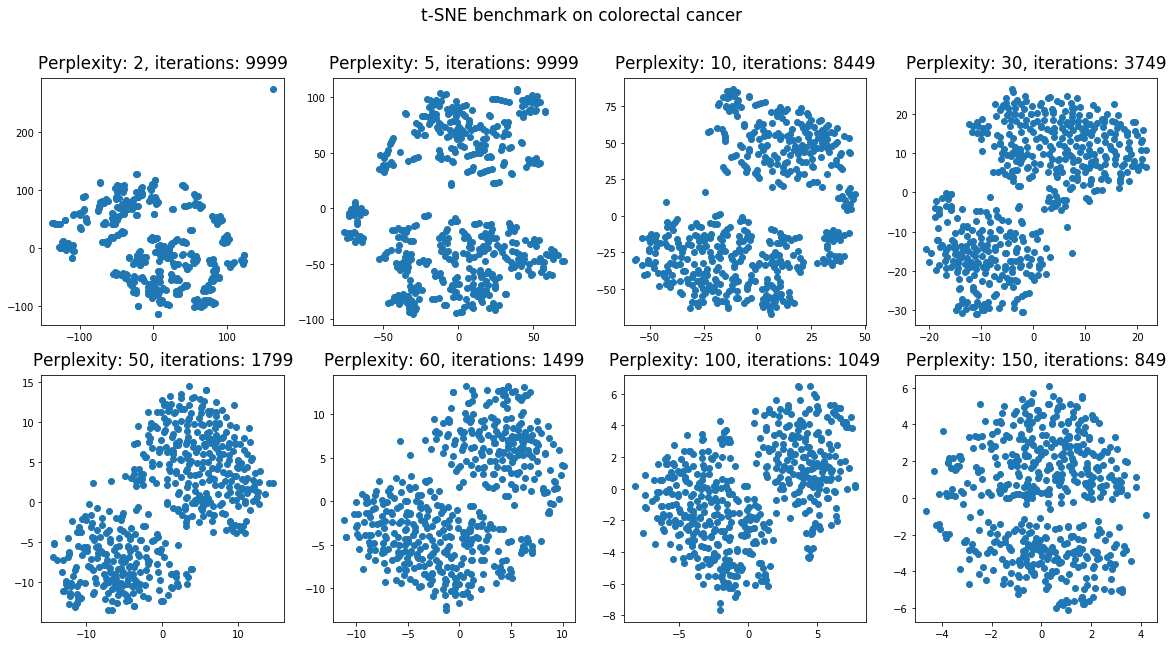

In [12]:
axes = [(i,j) for i in range(2) for j in range(4)]
fig, ax = plt.subplots(2,4, figsize=(20,10))

font = {'family' : 'DejaVu Sans',
        'size'   : 14}

plt.rc('font', **font)

fig.suptitle("t-SNE benchmark on colorectal cancer")


for i,v in sorted(enumerate(datasets.keys())):
    n_iter = datasets[v][1]
    axis=ax[axes[i]]
    axis.scatter(x=datasets[v][0][0],y=datasets[v][0][1])
    title = f'Perplexity: {v}, iterations: {n_iter}'
    axis.set_title(title, pad=10)

As we see from the clusters, the best one so far is definitely the t-SNE with perplexity 50, showing 2 well-defined clusters.

In [67]:
metadata["tsne1"] = datasets[50][0][0]
metadata["tsne2"] = datasets[50][0][1]

Text(0.5, 1.0, 'Tissue of origin')

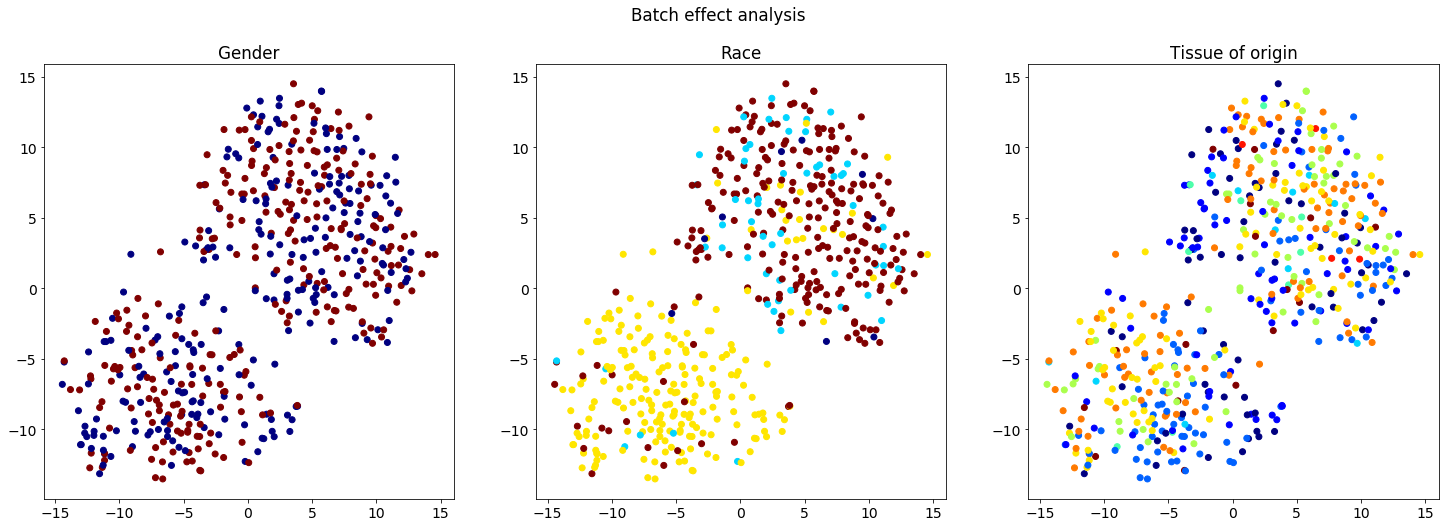

In [14]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

gender_encoded = label.fit_transform(metadata["gender"])
race_encoded = label.fit_transform(metadata["race"])
tissue_encoded = label.fit_transform(metadata["tissue_or_organ_of_origin"])
# 0 female, 1 male
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,8))

fig.suptitle("Batch effect analysis")

ax1.scatter(metadata["tsne1"],metadata["tsne2"], c=gender_encoded, cmap=plt.cm.jet)
ax1.set_title("Gender")
ax2.scatter(metadata["tsne1"],metadata["tsne2"], c=race_encoded, cmap=plt.cm.jet)
ax2.set_title("Race")
ax3.scatter(metadata["tsne1"],metadata["tsne2"], c=tissue_encoded, cmap=plt.cm.jet)
ax3.set_title("Tissue of origin")

From what we can see, it seems that no batch effect was found relative to sex, race or tissue of origin

In [68]:
metadata = metadata.replace(to_replace=["Stage IIA","Stage IIB","Stage IIC","Stage IID"], value="Stage II")
metadata = metadata.replace(to_replace=['Stage IIIA','Stage IIIB','Stage IIIC','Stage IIID'], value="Stage III")
metadata = metadata.replace(to_replace=['Stage IVA','Stage IVB','Stage IVC'], value="Stage IV")
metadata = metadata.replace(to_replace=['Stage IA','Stage IB'], value="Stage I")
metadata = metadata.replace('--', "Not reported")
pd.unique(metadata["ajcc_pathologic_stage"])

array(['Stage I', 'Stage III', 'Stage IV', 'Stage II', 'Not reported'],
      dtype=object)

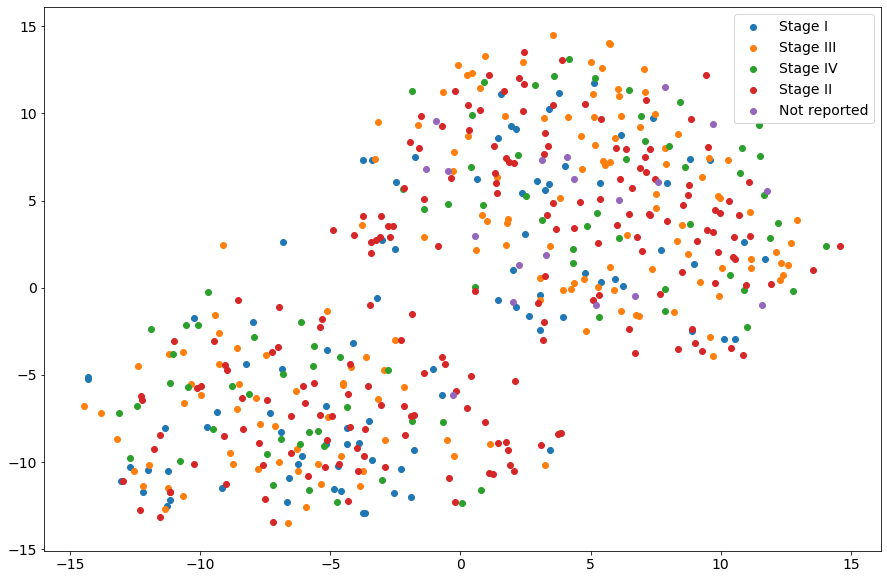

In [16]:
stages = label.fit_transform(metadata["ajcc_pathologic_stage"])
fig, ax = plt.subplots(figsize=(15,10))

for i,stage in enumerate(pd.unique(metadata["ajcc_pathologic_stage"])):
    x = metadata.loc[metadata["ajcc_pathologic_stage"]==stage,"tsne1"]
    y = metadata.loc[metadata["ajcc_pathologic_stage"]==stage,"tsne2"]
    plt.scatter(x, y, label=stage)

ax.legend()


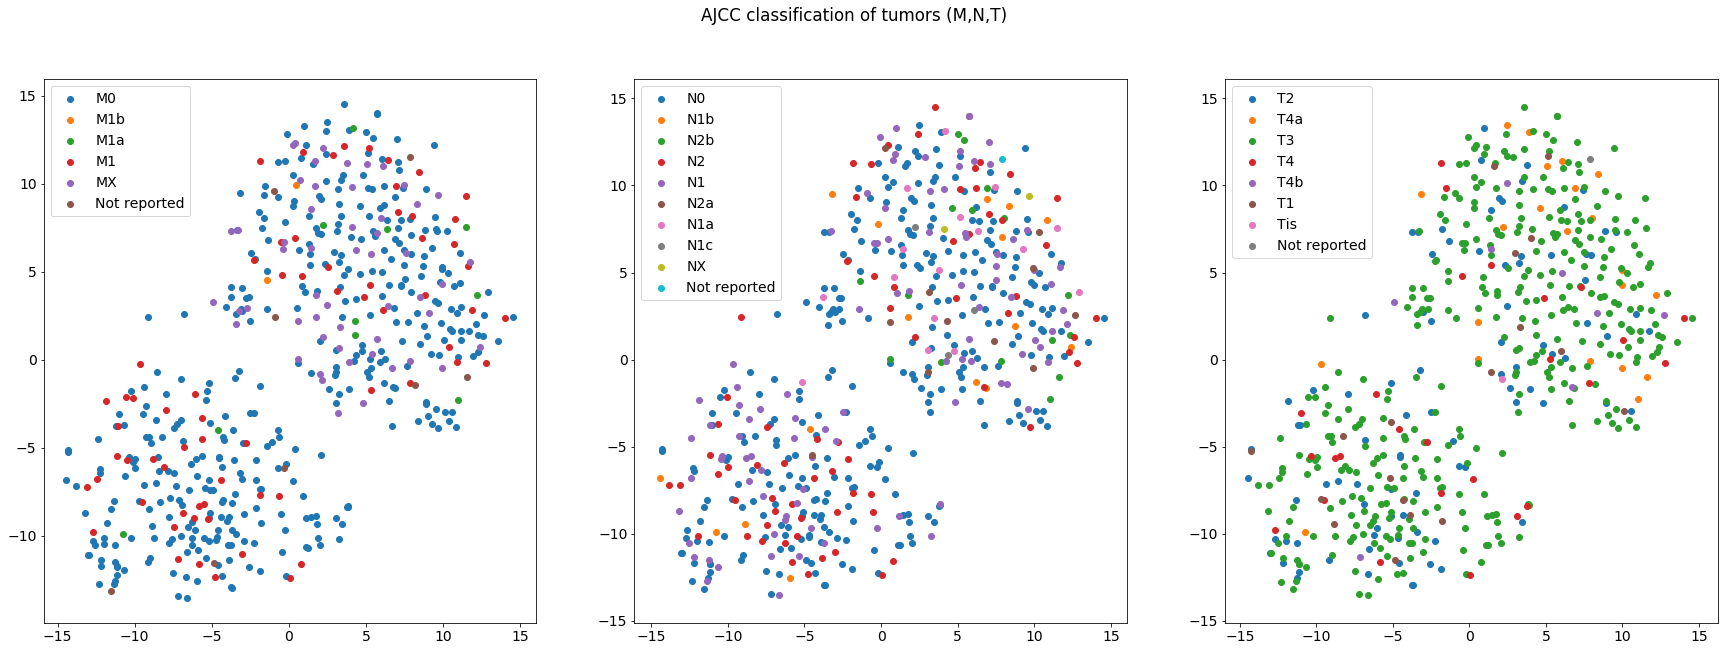

In [17]:
# T, M, N analysis
fig, ax = plt.subplots(1,3, figsize=(30,10))

fig.suptitle("AJCC classification of tumors (M,N,T)")

for i, label in enumerate(["ajcc_pathologic_m","ajcc_pathologic_n","ajcc_pathologic_t"]):
    plot=ax[i]
    
    for j,stage in enumerate(pd.unique(metadata[label])):
        x = metadata.loc[metadata[label]==stage,"tsne1"]
        y = metadata.loc[metadata[label]==stage,"tsne2"] 
        plot.scatter(x, y, label=stage)
    
    plot.legend()

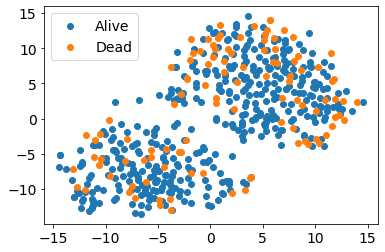

In [18]:
# dead vs alive
fig, plot = plt.subplots()

for i, status in enumerate(pd.unique(metadata.vital_status)):
    x = metadata.loc[metadata["vital_status"]==status,"tsne1"]
    y = metadata.loc[metadata["vital_status"]==status,"tsne2"] 
    plot.scatter(x, y, label=status)
    
plot.legend()

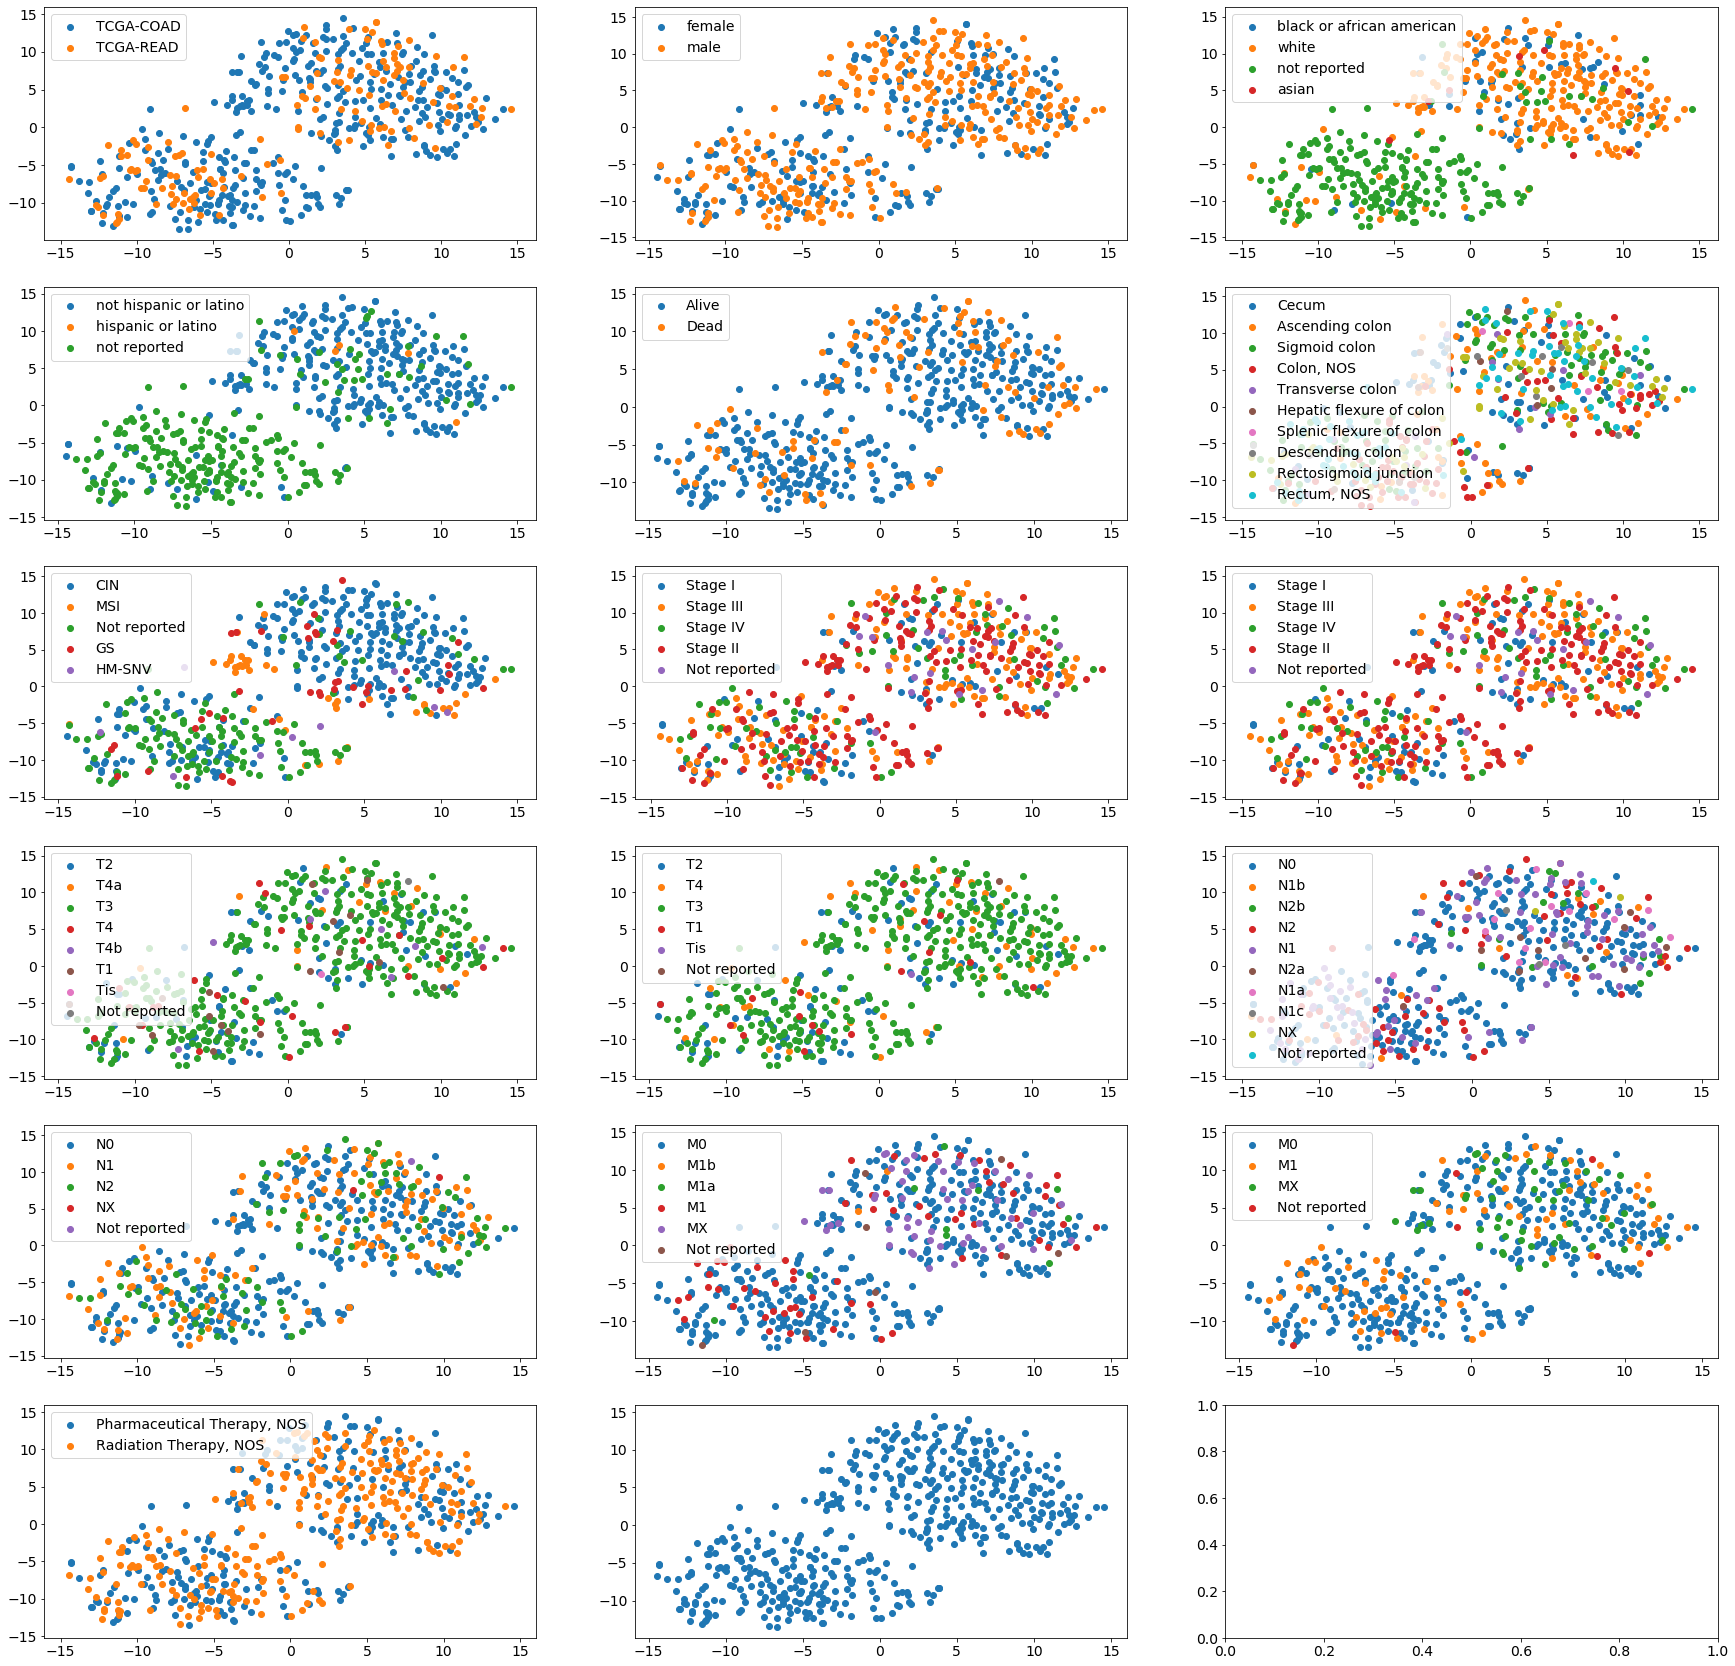

In [19]:
labels = ['project_id','gender', 'race', 'ethnicity',
       'vital_status', 'tissue_or_organ_of_origin', 'subtype', 'ajcc_pathologic_stage',
       'comp.stage', 'ajcc_pathologic_t', 'comp.t_size', 'ajcc_pathologic_n',
       'comp.ln_affected', 'ajcc_pathologic_m', 'comp.metastases',
       'treatment_type']

fig, ax = plt.subplots(6,3, figsize=(30,30))

axes = [(i,j) for i in range(6) for j in range(3)]

for i, label in enumerate(labels):
    plot = ax[axes[i]]
    for j, variable in enumerate(pd.unique(metadata[label])):
        x = metadata.loc[metadata[label]==variable,"tsne1"]
        y = metadata.loc[metadata[label]==variable,"tsne2"]
        plot.scatter(x,y,label=variable)
    plot.legend()
    
ax[5][1].scatter(metadata.tsne1,metadata.tsne2)

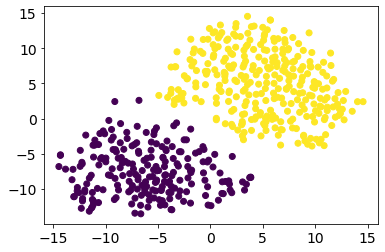

In [20]:
import sklearn.cluster

clusters = sklearn.cluster.KMeans(n_clusters=2).fit(metadata[["tsne1","tsne2"]])

plt.scatter(metadata.tsne1, metadata.tsne2, c=clusters.labels_)

In [51]:
# we want to define ownership to a cluster based on the expression value, 
# so for each gene you use a point biserial correlation

import scipy.stats

correlation_clusters = expr_matrix.apply(scipy.stats.pointbiserialr, y=clusters.labels_, axis=1)

In [52]:
correlations = pd.DataFrame(correlation_clusters.array, columns=["correlation", "pval"], index=correlation_clusters.index)

In [53]:
correlations.loc[abs(correlations["correlation"]) >= 0.8,:].to_csv("supergenes.txt")

In [54]:
abs(correlations["correlation"]) >= 0.8

ENSG00000227063.5     False
ENSG00000210140.1     False
ENSG00000115386.5     False
ENSG00000210144.1     False
ENSG00000159182.4     False
                      ...  
ENSG00000170581.12    False
ENSG00000170542.5     False
ENSG00000107738.18    False
ENSG00000250571.5     False
ENSG00000065357.18    False
Name: correlation, Length: 5692, dtype: bool

In [69]:
import re

labs = list()

for name in metadata.index.values:
    labs.append(re.match("TCGA-(\w+)-\w+", name).groups()[0])
    
metadata["labs"] = labs

In [70]:
tss = pd.read_csv("./tissueSourceSite.tsv", sep='\t')
tss.head()

TSS Code                        Source Site  \
0       01  International Genomics Consortium   
1       02          MD Anderson Cancer Center   
2       04         Gynecologic Oncology Group   
3       05                          Indivumed   
4       06                Henry Ford Hospital   

                          Study Name  BCR  
0  Ovarian serous cystadenocarcinoma  IGC  
1            Glioblastoma multiforme  IGC  
2  Ovarian serous cystadenocarcinoma  IGC  
3                Lung adenocarcinoma  IGC  
4            Glioblastoma multiforme  IGC

In [71]:
metadata_tss = pd.merge(metadata, tss, how='left', left_on="labs", right_on="TSS Code", left_index=True)

In [72]:
metadata_tss.index = metadata.index

In [73]:
metadata_tss.loc["TCGA-AU-6004",:]

project_id                                          TCGA-COAD
gender                                                 female
year_of_birth                                            1941
race                                                    white
ethnicity                              not hispanic or latino
vital_status                                            Alive
days_to_death                                    Not reported
days_to_last_follow_up                                    824
tissue_or_organ_of_origin                               Cecum
subtype                                                   MSI
ajcc_pathologic_stage                                 Stage I
comp.stage                                            Stage I
ajcc_pathologic_t                                          T2
comp.t_size                                                T2
ajcc_pathologic_n                                          N0
comp.ln_affected                                           N0
ajcc_pat

In [74]:
metadata_tss.to_csv("../../data/metadata_batch.csv", index_label=False, sep='\t')

In [107]:
metadata_tss.sample(15)

project_id  gender  year_of_birth                       race  \
TCGA-EI-6512  TCGA-READ  female           1946                      white   
TCGA-DC-6156  TCGA-READ    male           1948                      white   
TCGA-AA-3530  TCGA-COAD    male           1927               not reported   
TCGA-AA-3488  TCGA-COAD    male           1944               not reported   
TCGA-DC-4745  TCGA-READ  female           1961                      white   
TCGA-AF-2693  TCGA-READ    male           1934                      white   
TCGA-5M-AATE  TCGA-COAD    male           1935  black or african american   
TCGA-AG-3896  TCGA-READ  female           1924               not reported   
TCGA-3L-AA1B  TCGA-COAD  female           1952  black or african american   
TCGA-AG-3728  TCGA-READ    male           1933               not reported   
TCGA-AG-3583  TCGA-READ    male           1942               not reported   
TCGA-DC-6683  TCGA-READ    male           1968                      white   
TCGA-AA-3511  TCGA-COAD    male           1941               not reported   
TCGA-NH-A6GB  TCGA-COAD  female           1942  black or african american   
TCGA-CA-5256  TCGA-COAD  female           1956                      asian   

                           ethnicity vital_status days_to_death  \
TCGA-EI-6512  not hispanic or latino        Alive  Not reported   
TCGA-DC-6156  not hispanic or latino        Alive  Not reported   
TCGA-AA-3530            not reported        Alive  Not reported   
TCGA-AA-3488            not reported         Dead           153   
TCGA-DC-4745  not hispanic or latino        Alive  Not reported   
TCGA-AF-2693  not hispanic or latino        Alive  Not reported   
TCGA-5M-AATE      hispanic or latino        Alive  Not reported   
TCGA-AG-3896            not reported        Alive  Not reported   
TCGA-3L-AA1B  not hispanic or latino        Alive  Not reported   
TCGA-AG-3728            not reported        Alive  Not reported   
TCGA-AG-3583            not reported         Dead           610   
TCGA-DC-6683  not hispanic or latino        Alive  Not reported   
TCGA-AA-3511            not reported        Alive  Not reported   
TCGA-NH-A6GB  not hispanic or latino        Alive  Not reported   
TCGA-CA-5256            not reported        Alive  Not reported   

             days_to_last_follow_up tissue_or_organ_of_origin       subtype  \
TCGA-EI-6512                    538               Rectum, NOS           CIN   
TCGA-DC-6156                    943     Rectosigmoid junction  Not reported   
TCGA-AA-3530                    580                Colon, NOS  Not reported   
TCGA-AA-3488           Not reported     Rectosigmoid junction  Not reported   
TCGA-DC-4745                    639     Rectosigmoid junction           CIN   
TCGA-AF-2693                   1155     Rectosigmoid junction           CIN   
TCGA-5M-AATE                   1200           Ascending colon           CIN   
TCGA-AG-3896                     31               Rectum, NOS           CIN   
TCGA-3L-AA1B                    475                     Cecum           CIN   
TCGA-AG-3728                    912               Rectum, NOS  Not reported   
TCGA-AG-3583                     61     Rectosigmoid junction  Not reported   
TCGA-DC-6683                    762     Rectosigmoid junction           CIN   
TCGA-AA-3511                    212                Colon, NOS           CIN   
TCGA-NH-A6GB                    476          Transverse colon           CIN   
TCGA-CA-5256                    379                Colon, NOS           CIN   

              ...               treatment_type       pca1       pca2  \
TCGA-EI-6512  ...  Pharmaceutical Therapy, NOS   9.118345  -9.931396   
TCGA-DC-6156  ...  Pharmaceutical Therapy, NOS  -7.768729 -46.455618   
TCGA-AA-3530  ...  Pharmaceutical Therapy, NOS -16.511602   8.280948   
TCGA-AA-3488  ...       Radiation Therapy, NOS  -1.491343  55.696432   
TCGA-DC-4745  ...  Pharmaceutical Therapy, NOS  11.039224  -4.312429   
TCGA-AF-26

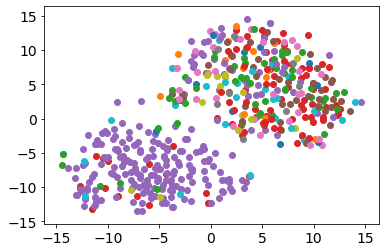

In [26]:
fig, plot = plt.subplots()

for i, labs in enumerate(pd.unique(metadata_tss["Source Site"])):
    x = metadata_tss.loc[metadata_tss["Source Site"]==labs,"tsne1"]
    y = metadata_tss.loc[metadata_tss["Source Site"]==labs,"tsne2"]
    plot.scatter(x, y, label=labs)
    
#plot.legend()

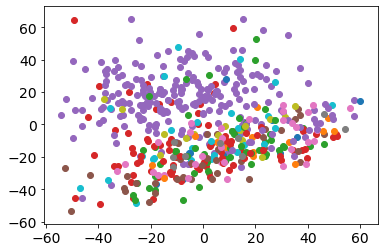

In [27]:
fig, plot = plt.subplots()

for i, labs in enumerate(pd.unique(metadata_tss["Source Site"])):
    x = metadata_tss.loc[metadata_tss["Source Site"]==labs,"pca1"]
    y = metadata_tss.loc[metadata_tss["Source Site"]==labs,"pca2"]
    plot.scatter(x, y, label=labs)
    
# plot.legend()

In [28]:
metadata_batch = metadata_tss.loc[metadata_tss["Source Site"]!="Indivumed",:]
metadata_batch.shape

(312, 28)

In [29]:
metadata_batch.columns

Index(['project_id', 'gender', 'year_of_birth', 'race', 'ethnicity',
       'vital_status', 'days_to_death', 'days_to_last_follow_up',
       'tissue_or_organ_of_origin', 'subtype', 'ajcc_pathologic_stage',
       'comp.stage', 'ajcc_pathologic_t', 'comp.t_size', 'ajcc_pathologic_n',
       'comp.ln_affected', 'ajcc_pathologic_m', 'comp.metastases',
       'treatment_type', 'pca1', 'pca2', 'tsne1', 'tsne2', 'labs', 'TSS Code',
       'Source Site', 'Study Name', 'BCR'],
      dtype='object')

In [30]:
expr_matrix_batch = expr_matrix.loc[:,metadata_batch.index]

In [31]:
expr_matrix_batch.shape

(5692, 312)

Calculations over!


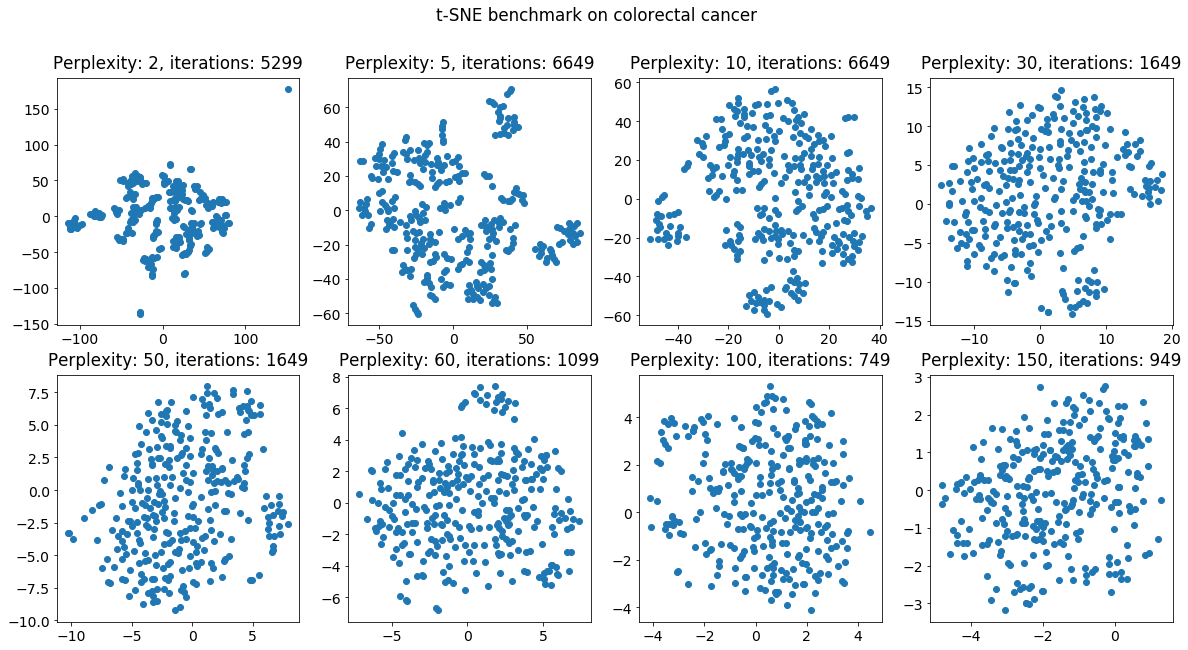

In [32]:
# run t-SNE with different perplexity values until convergence every time 
# and every time judge the quality of the dimensionality reduction
datasets_tss = dict()

for perp in [2,5,10,30,50,60,100,150]:
    tsne = sklearn.manifold.TSNE(learning_rate=10, perplexity=perp, n_iter=10000).fit(expr_matrix_batch.T)
    datasets_tss[perp] = (tsne.embedding_.T, tsne.n_iter_)

print("Calculations over!")

# Now we visualize the output for each value of the perplexity to inspect visually the results

axes = [(i,j) for i in range(2) for j in range(4)]
fig, ax = plt.subplots(2,4, figsize=(20,10))

font = {'family' : 'DejaVu Sans',
        'size'   : 14}

plt.rc('font', **font)

fig.suptitle("t-SNE benchmark on colorectal cancer")


for i,v in sorted(enumerate(datasets_tss.keys())):
    n_iter = datasets_tss[v][1]
    axis=ax[axes[i]]
    axis.scatter(x=datasets_tss[v][0][0],y=datasets_tss[v][0][1])
    title = f'Perplexity: {v}, iterations: {n_iter}'
    axis.set_title(title, pad=10)

In [33]:
metadata_tss.shape

(525, 28)

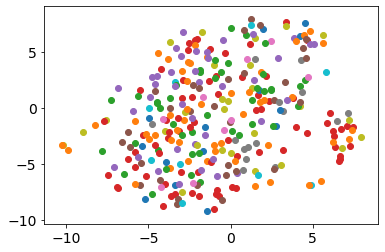

In [35]:
fig, plot = plt.subplots()

for i, labs in enumerate(pd.unique(metadata_batch["Source Site"])):
    x = metadata_batch.loc[metadata_batch["Source Site"]==labs,"tsne1"]
    y = metadata_batch.loc[metadata_batch["Source Site"]==labs,"tsne2"]
    plot.scatter(x, y, label=labs)
    
# plot.legend()

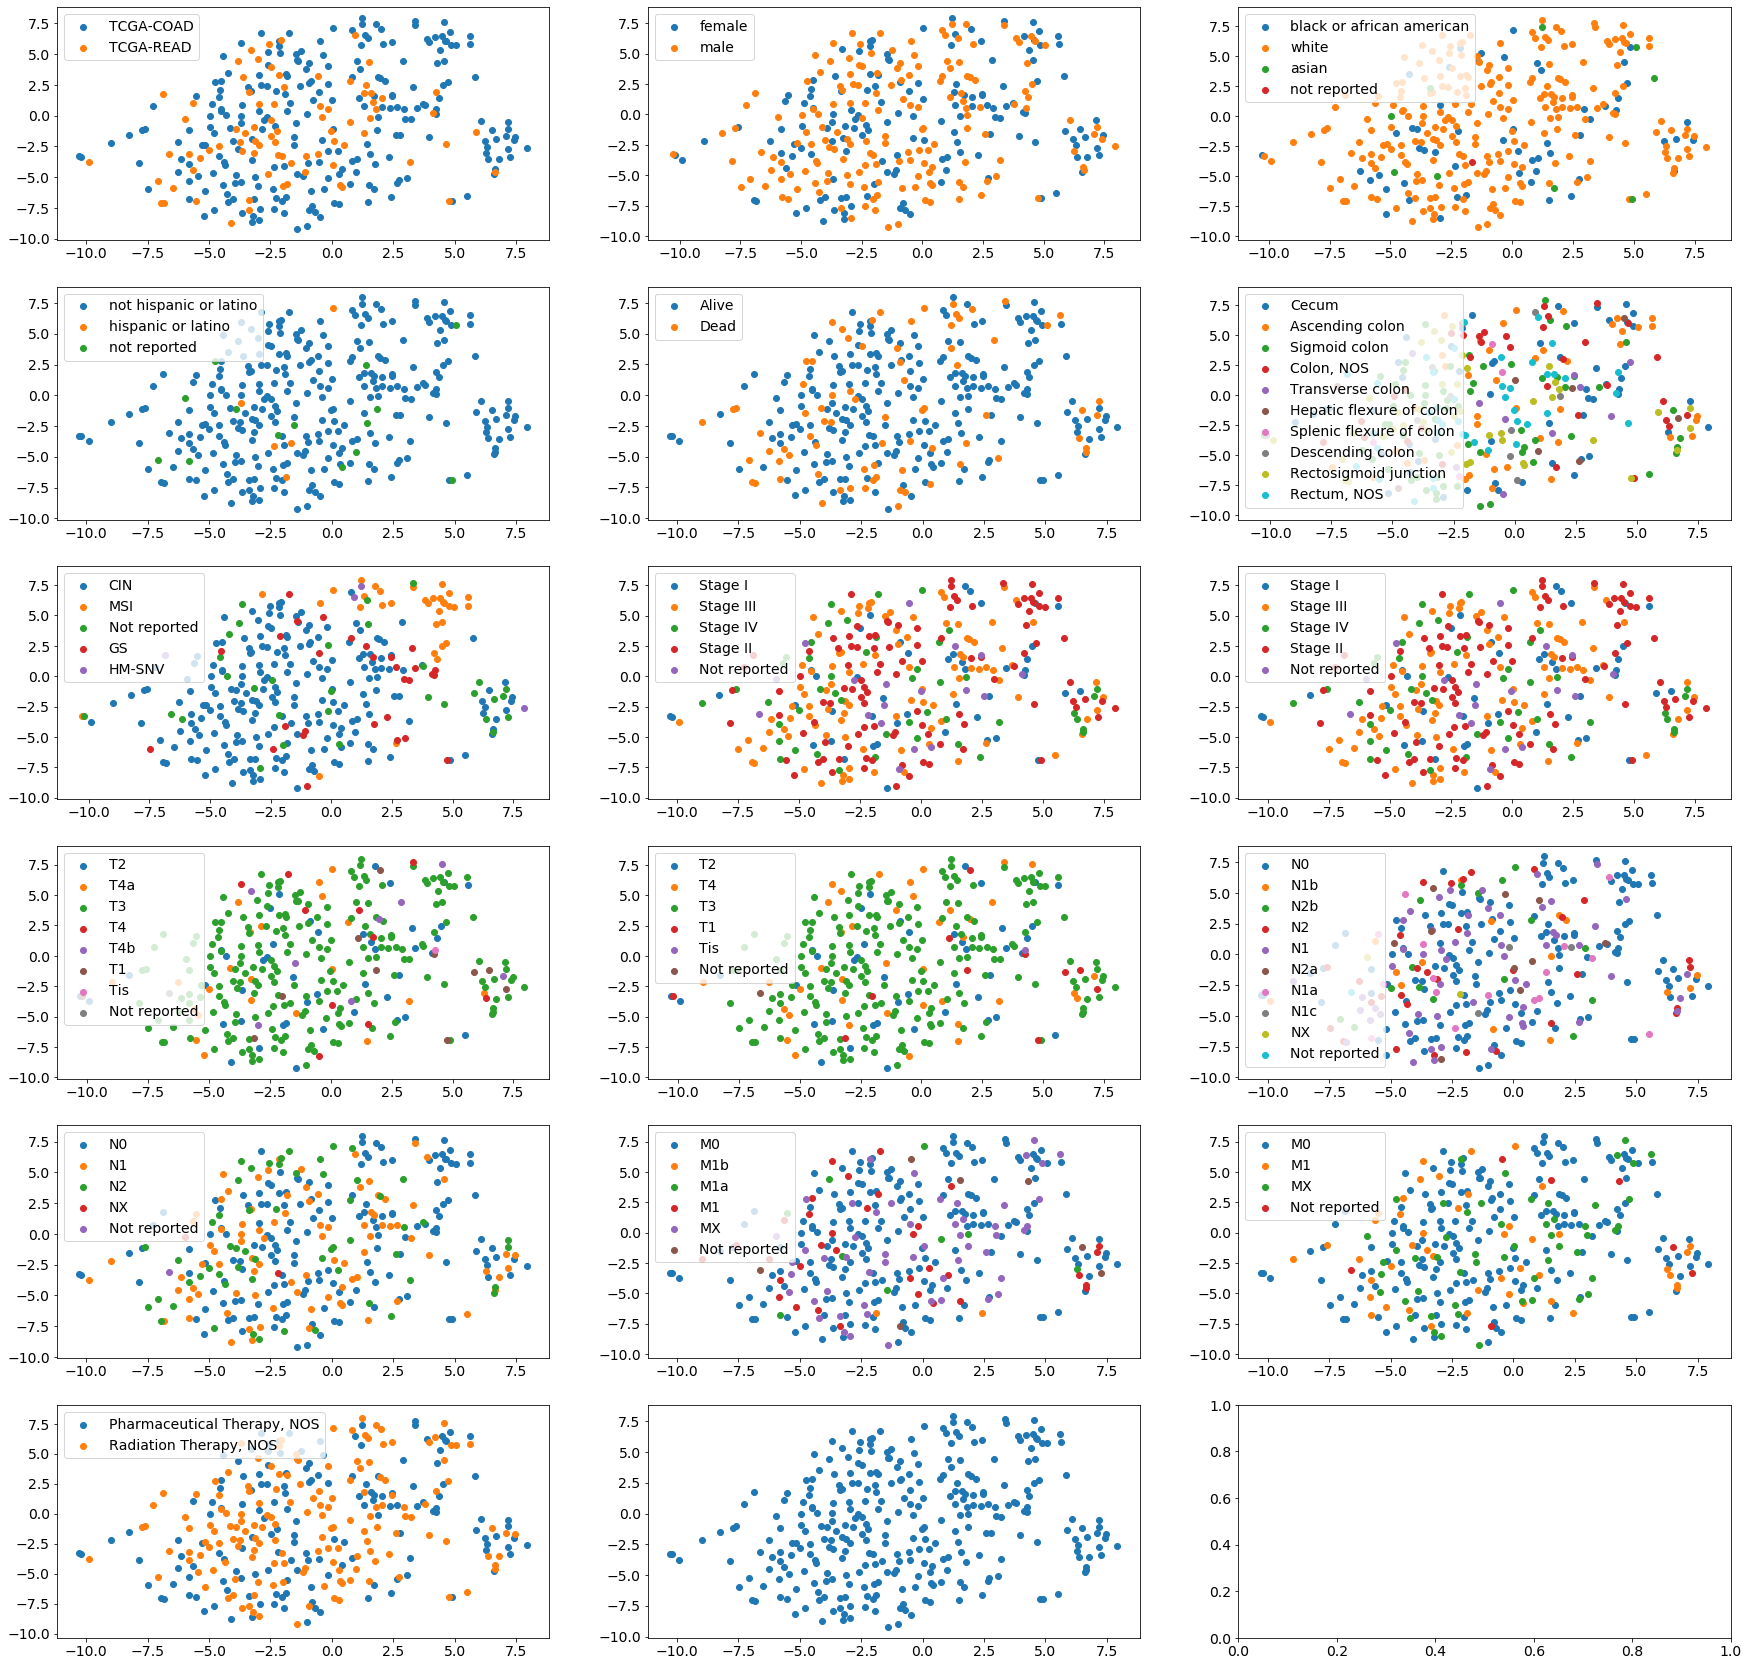

In [36]:
labels = ['project_id','gender', 'race', 'ethnicity',
       'vital_status', 'tissue_or_organ_of_origin', 'subtype', 'ajcc_pathologic_stage',
       'comp.stage', 'ajcc_pathologic_t', 'comp.t_size', 'ajcc_pathologic_n',
       'comp.ln_affected', 'ajcc_pathologic_m', 'comp.metastases',
       'treatment_type']

fig, ax = plt.subplots(6,3, figsize=(30,30))

axes = [(i,j) for i in range(6) for j in range(3)]

for i, label in enumerate(labels):
    plot = ax[axes[i]]
    for j, variable in enumerate(pd.unique(metadata_batch[label])):
        x = metadata_batch.loc[metadata_batch[label]==variable,"tsne1"]
        y = metadata_batch.loc[metadata_batch[label]==variable,"tsne2"]
        plot.scatter(x,y,label=variable)
    plot.legend()
    
ax[5][1].scatter(metadata_batch.tsne1,metadata_batch.tsne2)

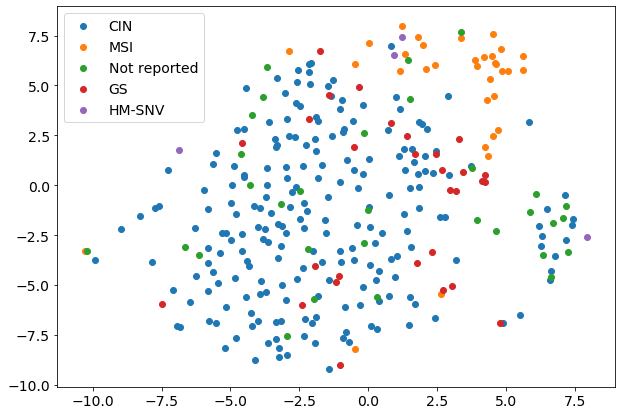

In [110]:
fig, plot = plt.subplots(figsize=(10,7))

for j, variable in enumerate(pd.unique(metadata_batch["subtype"])):
    x = metadata_batch.loc[metadata_batch["subtype"]==variable,"tsne1"]
    y = metadata_batch.loc[metadata_batch["subtype"]==variable,"tsne2"]
    plot.scatter(x,y,label=variable)
plot.legend()

In [37]:
# reduce to 30 dimensions with PCA
pca_batch = sklearn.decomposition.PCA(n_components=2)
flat_mat_batch = pca.fit_transform(expr_matrix_batch.T)

metadata_batch["pca1"] = flat_mat_batch.T[0]
metadata_batch["pca2"] = flat_mat_batch.T[1]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


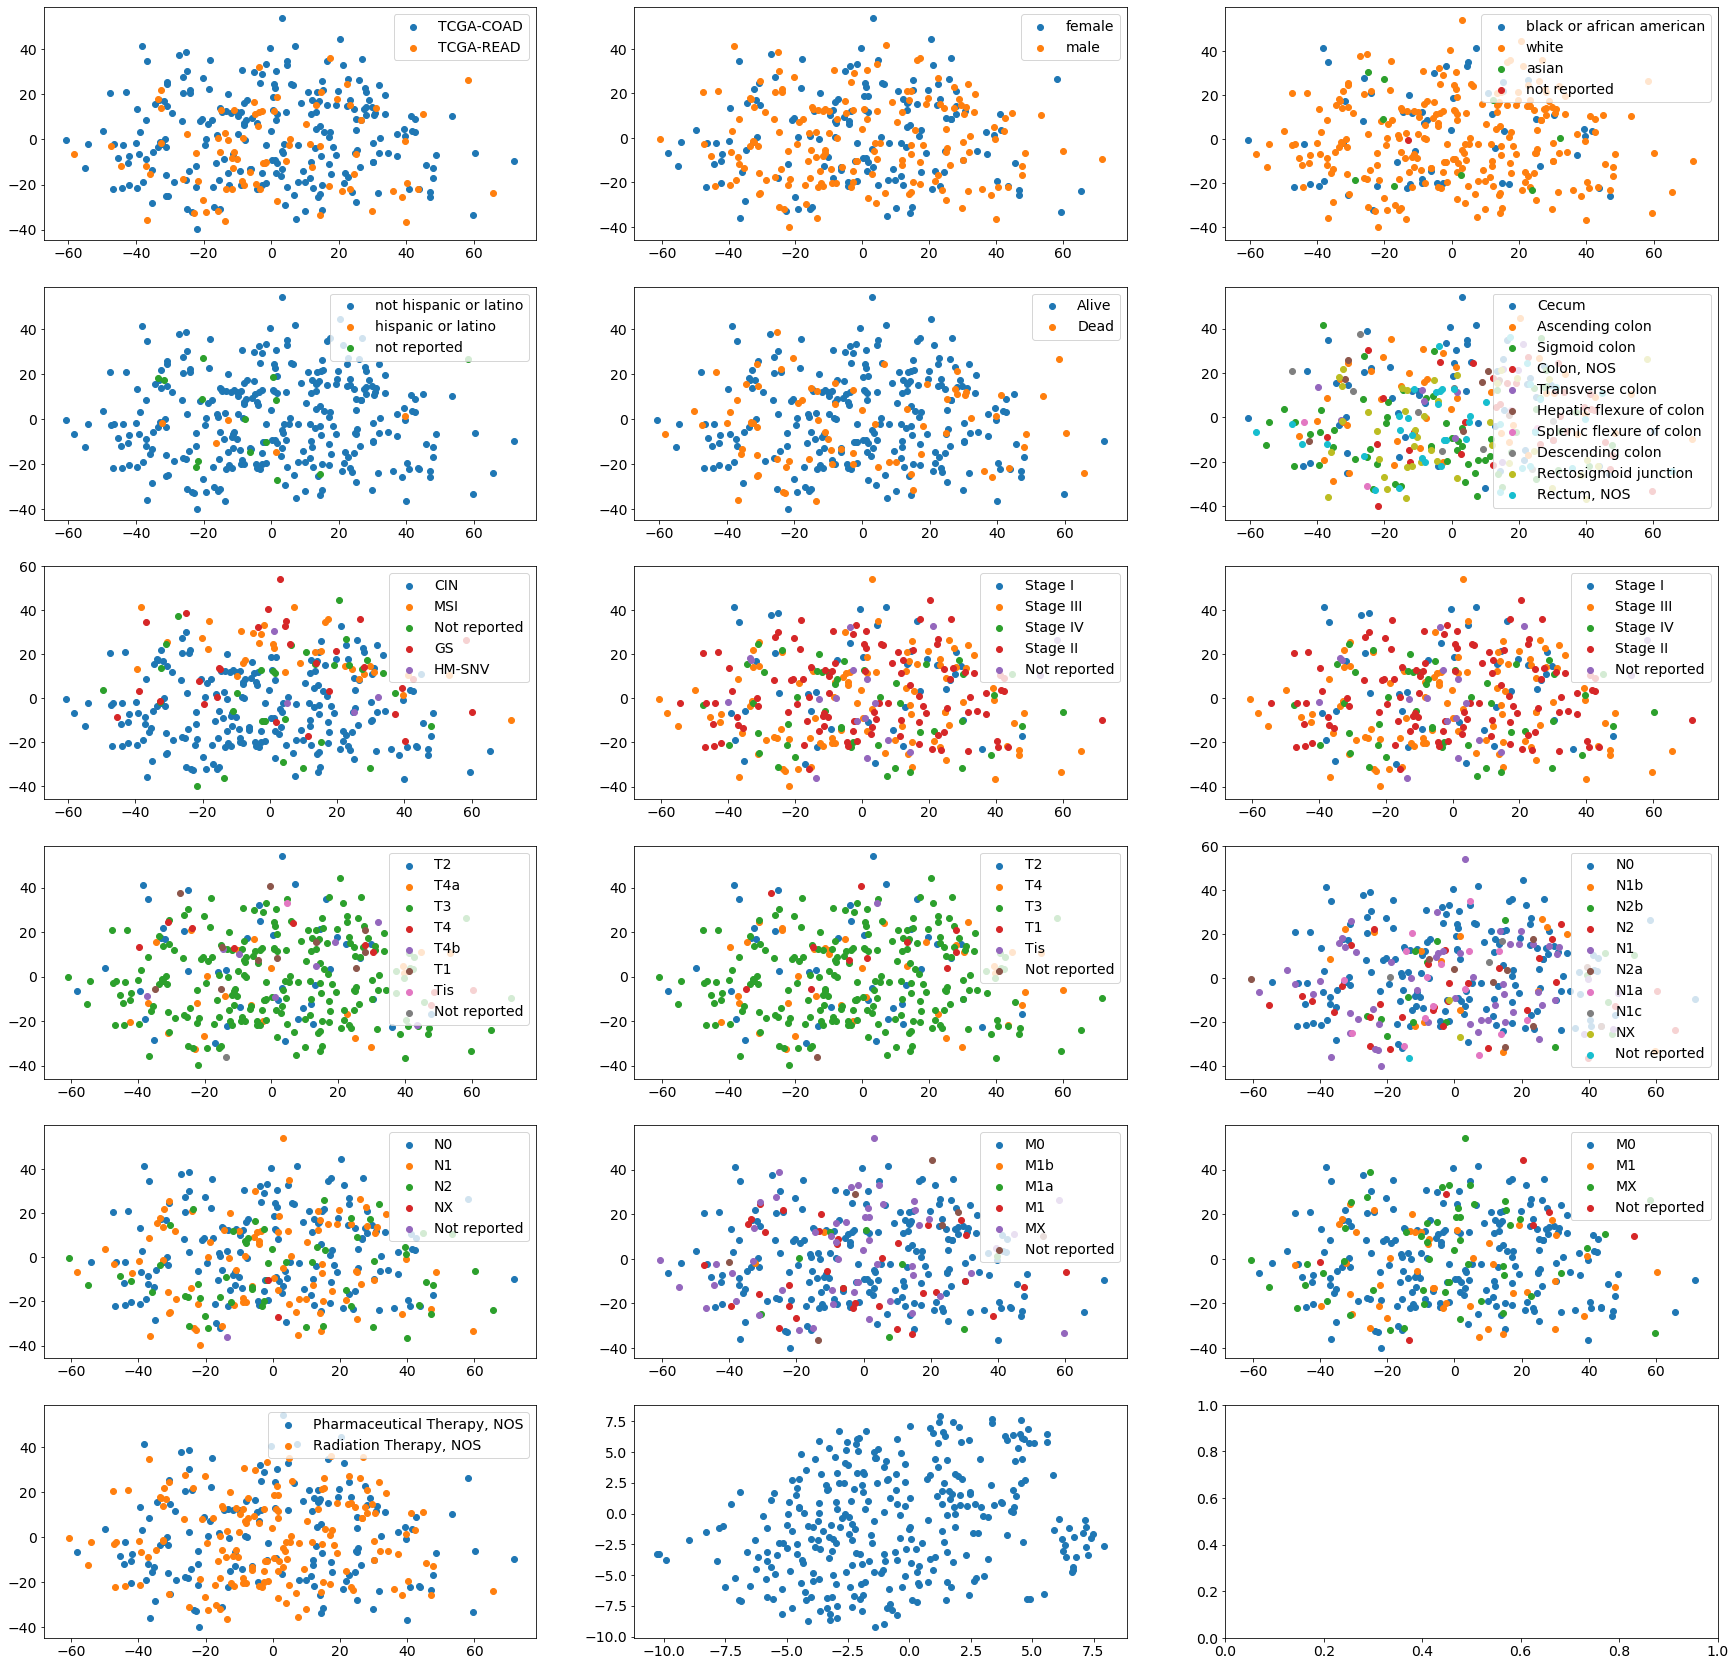

In [38]:
labels = ['project_id','gender', 'race', 'ethnicity',
       'vital_status', 'tissue_or_organ_of_origin', 'subtype', 'ajcc_pathologic_stage',
       'comp.stage', 'ajcc_pathologic_t', 'comp.t_size', 'ajcc_pathologic_n',
       'comp.ln_affected', 'ajcc_pathologic_m', 'comp.metastases',
       'treatment_type']

fig, ax = plt.subplots(6,3, figsize=(30,30))

axes = [(i,j) for i in range(6) for j in range(3)]

for i, label in enumerate(labels):
    plot = ax[axes[i]]
    for j, variable in enumerate(pd.unique(metadata_batch[label])):
        x = metadata_batch.loc[metadata_batch[label]==variable,"pca1"]
        y = metadata_batch.loc[metadata_batch[label]==variable,"pca2"]
        plot.scatter(x,y,label=variable)
    plot.legend()
    
ax[5][1].scatter(metadata_batch.tsne1,metadata_batch.tsne2)

In [39]:
expr_batch_free = pd.read_csv("../../data/filtered_genes_FPKM_batchfree.csv", header=0, index_col=0)

In [75]:
expr_batch_free.shape

(5692, 524)

Calculations over!


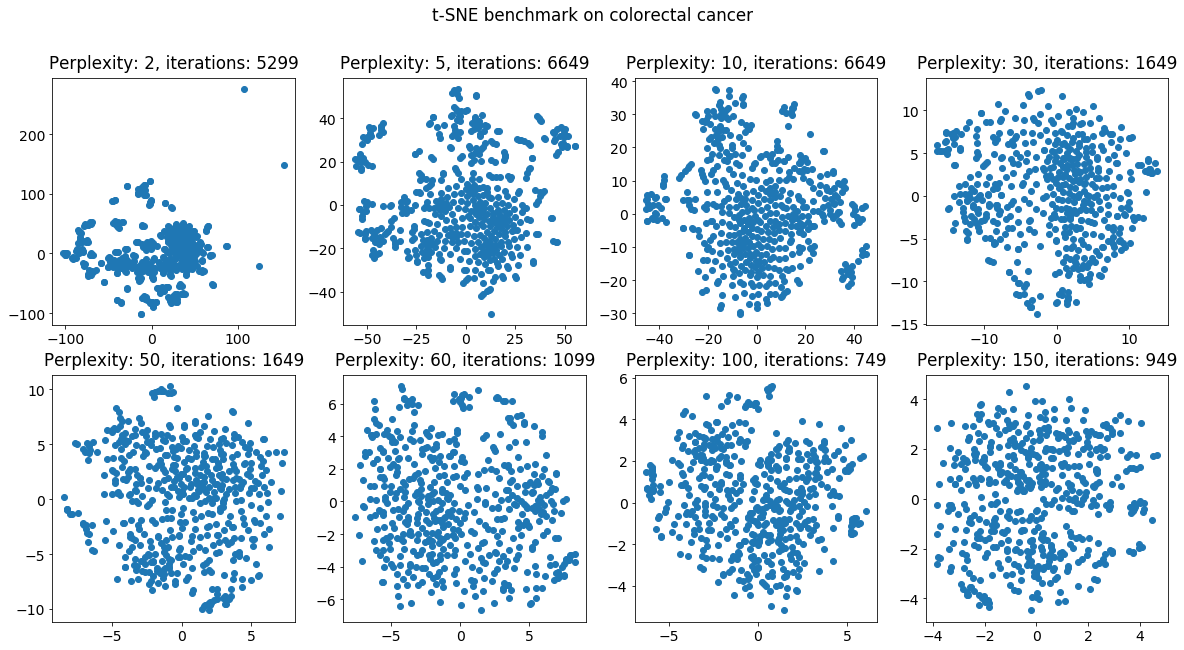

In [95]:
# and every time judge the quality of the dimensionality reduction
datasets_batchfree = dict()

for perp in [2,5,10,30,50,60,100,150]:
    tsne = sklearn.manifold.TSNE(learning_rate=10, perplexity=perp, n_iter=10000).fit(expr_batch_free.T)
    datasets_batchfree[perp] = (tsne.embedding_.T, tsne.n_iter_)

print("Calculations over!")

# Now we visualize the output for each value of the perplexity to inspect visually the results

axes = [(i,j) for i in range(2) for j in range(4)]
fig, ax = plt.subplots(2,4, figsize=(20,10))

font = {'family' : 'DejaVu Sans',
        'size'   : 14}

plt.rc('font', **font)

fig.suptitle("t-SNE benchmark on colorectal cancer")


for i,v in sorted(enumerate(datasets_batchfree.keys())):
    n_iter = datasets_tss[v][1]
    axis=ax[axes[i]]
    axis.scatter(x=datasets_batchfree[v][0][0],y=datasets_batchfree[v][0][1])
    title = f'Perplexity: {v}, iterations: {n_iter}'
    axis.set_title(title, pad=10)

In [99]:
metadata_batchfree["tsne1"] = datasets_batchfree[100][0][0]
metadata_batchfree["tsne2"] = datasets_batchfree[100][0][1]

In [97]:
datasets_batchfree[50][0].shape

(2, 524)

In [79]:
metadata_batchfree = metadata_tss

In [83]:
metadata_batchfree = metadata_batchfree.drop(["TCGA-AU-6004"], axis=0)

In [84]:
metadata_batchfree.shape

(524, 28)

In [85]:
expr_batch_free.shape

(5692, 524)

In [87]:
np.setdiff1d(metadata_batchfree.index.values, expr_batch_free.columns.values)

array([], dtype=object)

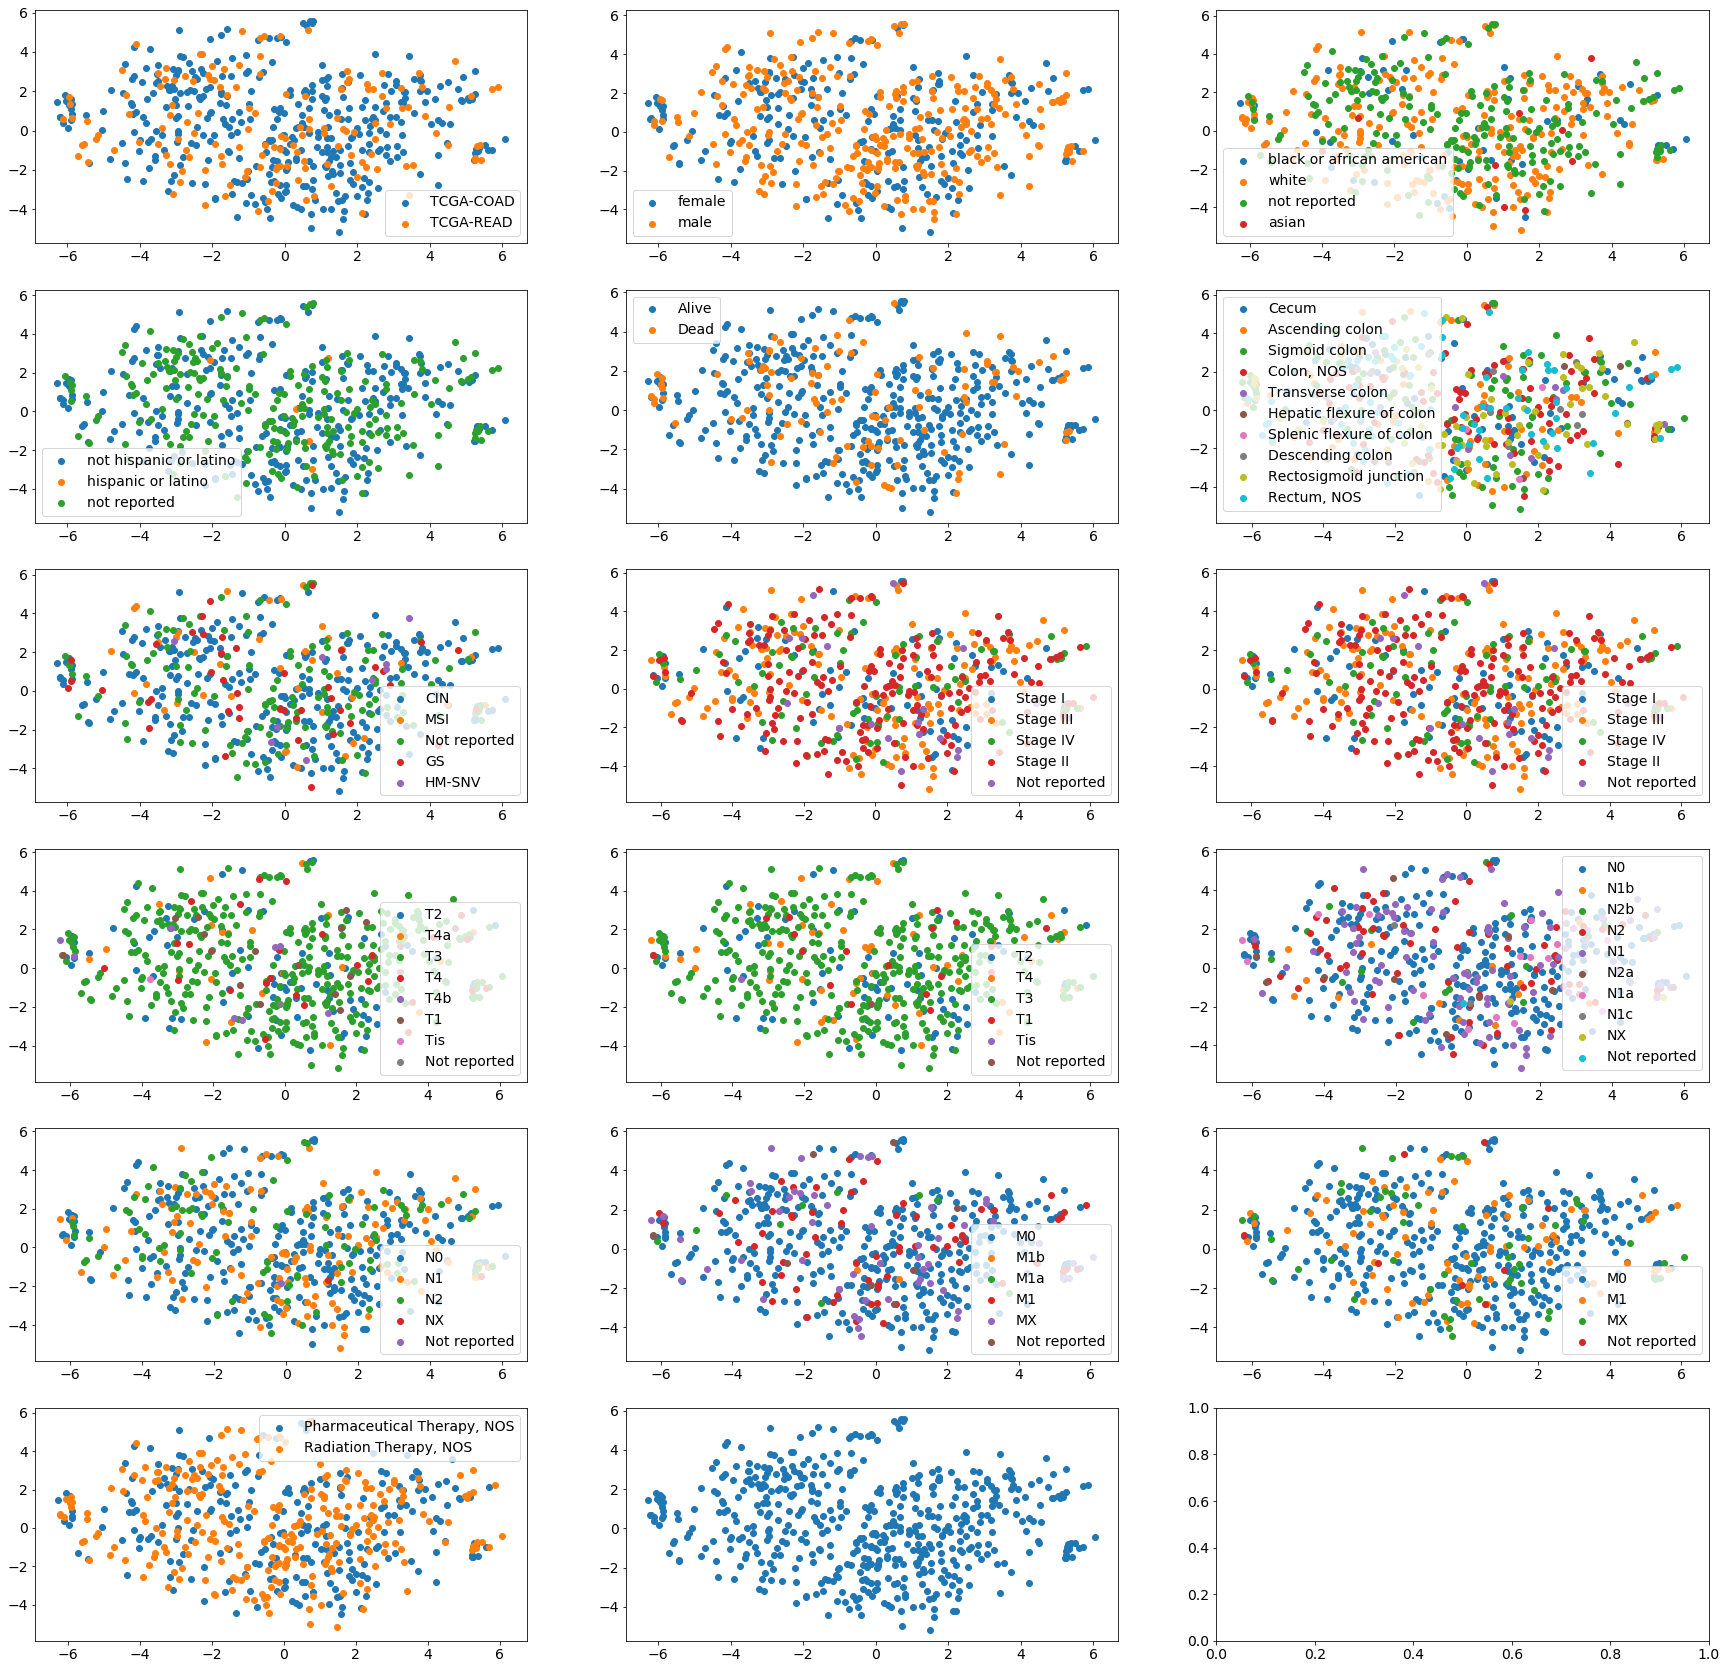

In [100]:
labels = ['project_id','gender', 'race', 'ethnicity',
       'vital_status', 'tissue_or_organ_of_origin', 'subtype', 'ajcc_pathologic_stage',
       'comp.stage', 'ajcc_pathologic_t', 'comp.t_size', 'ajcc_pathologic_n',
       'comp.ln_affected', 'ajcc_pathologic_m', 'comp.metastases',
       'treatment_type']

fig, ax = plt.subplots(6,3, figsize=(30,30))

axes = [(i,j) for i in range(6) for j in range(3)]

for i, label in enumerate(labels):
    plot = ax[axes[i]]
    for j, variable in enumerate(pd.unique(metadata_batchfree[label])):
        x = metadata_batchfree.loc[metadata_batchfree[label]==variable,"tsne1"]
        y = metadata_batchfree.loc[metadata_batchfree[label]==variable,"tsne2"]
        plot.scatter(x,y,label=variable)
    plot.legend()
    
ax[5][1].scatter(metadata_batchfree.tsne1,metadata_batchfree.tsne2)

In [101]:
# reduce to 30 dimensions with PCA
pca = sklearn.decomposition.PCA(n_components=2)
flat_mat = pca.fit_transform(expr_batch_free.T)

metadata_batchfree["pca1"] = flat_mat.T[0]
metadata_batchfree["pca2"] = flat_mat.T[1]

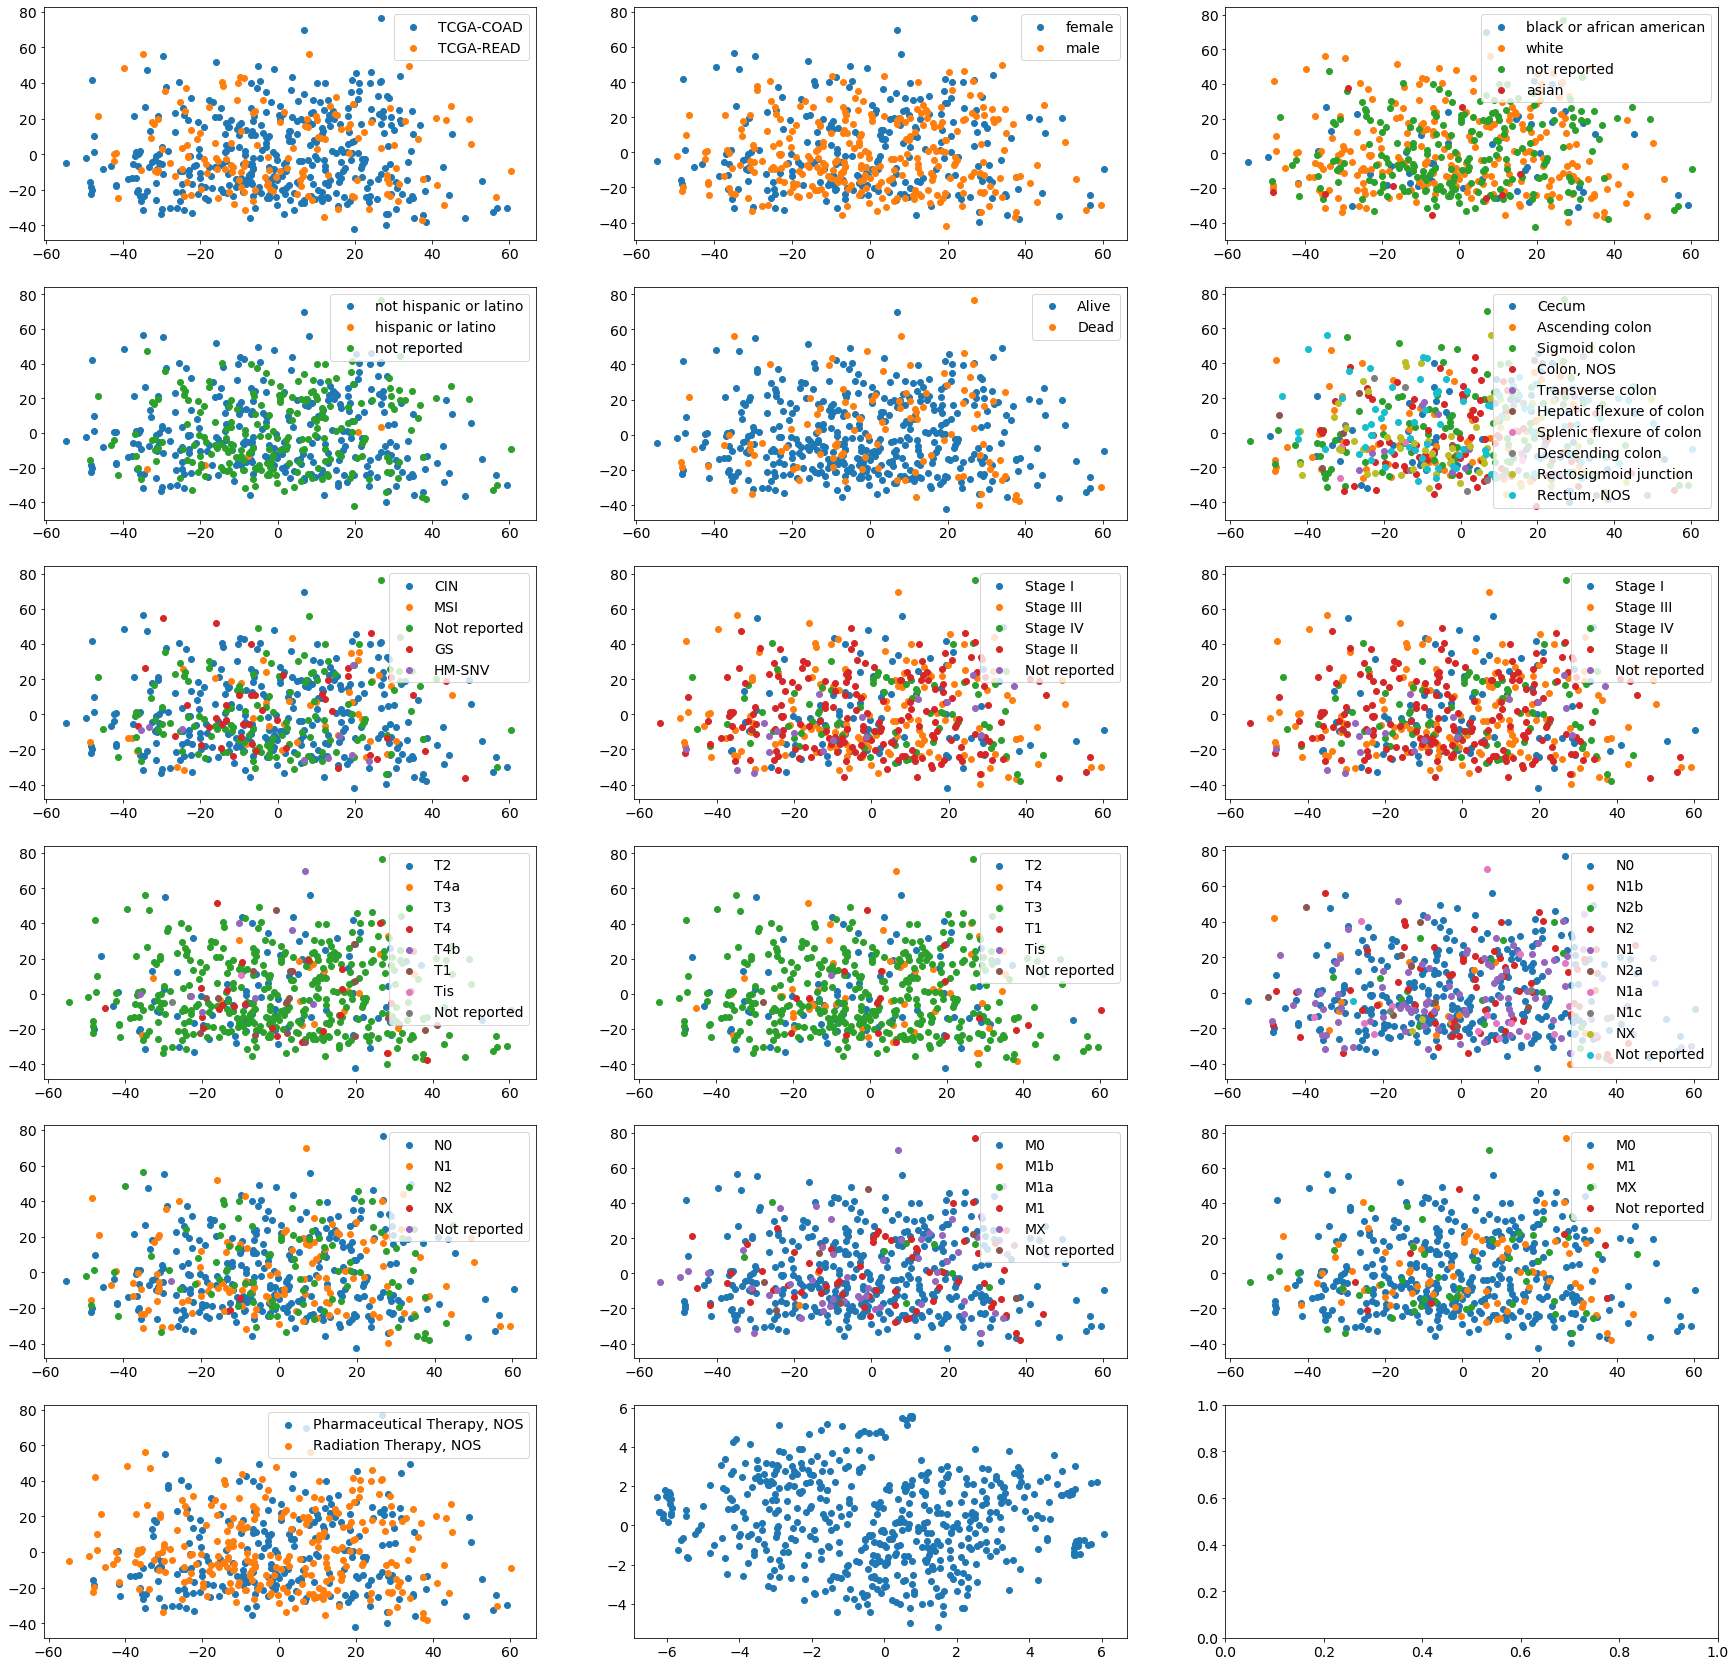

In [102]:
labels = ['project_id','gender', 'race', 'ethnicity',
       'vital_status', 'tissue_or_organ_of_origin', 'subtype', 'ajcc_pathologic_stage',
       'comp.stage', 'ajcc_pathologic_t', 'comp.t_size', 'ajcc_pathologic_n',
       'comp.ln_affected', 'ajcc_pathologic_m', 'comp.metastases',
       'treatment_type']

fig, ax = plt.subplots(6,3, figsize=(30,30))

axes = [(i,j) for i in range(6) for j in range(3)]

for i, label in enumerate(labels):
    plot = ax[axes[i]]
    for j, variable in enumerate(pd.unique(metadata_batchfree[label])):
        x = metadata_batchfree.loc[metadata_batchfree[label]==variable,"pca1"]
        y = metadata_batchfree.loc[metadata_batchfree[label]==variable,"pca2"]
        plot.scatter(x,y,label=variable)
    plot.legend()
    
ax[5][1].scatter(metadata_batchfree.tsne1,metadata_batchfree.tsne2)

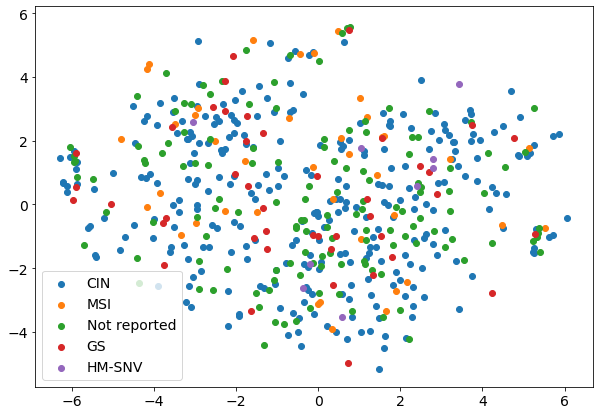

In [111]:
fig, plot = plt.subplots(figsize=(10,7))

for i, labs in enumerate(pd.unique(metadata_batchfree["subtype"])):
    x = metadata_batchfree.loc[metadata_batchfree["subtype"]==labs,"tsne1"]
    y = metadata_batchfree.loc[metadata_batchfree["subtype"]==labs,"tsne2"]
    plot.scatter(x, y, label=labs)
    
plot.legend()